# INM707: Advanced Tasks

We ...

The work presented here is part of the coursework of the INM707 module at City, University of London. The Github repository can be found [here](https://github.com/yasirbarlas/City-INM707).

### Import Libraries

We use NumPy for most of the class and environment creation. Matplotlib is used for visualising the environment and for generating any plots.

In [7]:
# Import Relevant Libraries
from collections import namedtuple, deque
from itertools import count
from IPython.display import clear_output

import numpy as np
import random
import math
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import torch.nn.functional as F

import gymnasium as gym
from vizdoom import gymnasium_wrapper

### Set Random Seed and Default Device

In order to reproduce the results every time we run the notebook, we set a random seed. We also try to use a GPU if available.

In [8]:
# Set random seed for reproducibility
randomer = 50
random.seed(randomer)
np.random.seed(randomer)
torch.manual_seed(randomer)
torch.cuda.manual_seed_all(randomer)

# Default device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Replay Buffer

In [9]:
class ReplayBuffer(object):
    def __init__(self, capacity):
        self.buffer = deque(maxlen = capacity)
    
    def push(self, state, action, reward, next_state, done):
        state = np.expand_dims(state, 0)
        next_state = np.expand_dims(next_state, 0)
            
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        return np.concatenate(state), action, reward, np.concatenate(next_state), done
    
    def __len__(self):
        return len(self.buffer)

### Deep Q-Network

In [10]:
class DQN(nn.Module):
    def __init__(self, num_inputs, num_actions):
        super(DQN, self).__init__()

        self.num_actions = num_actions
        
        self.layers = nn.Sequential(
            nn.Linear(num_inputs, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, num_actions)
        )
        
    def forward(self, x):
        return self.layers(x)
    
    def act(self, state, epsilon):
        if random.random() > epsilon:
            state = torch.FloatTensor(state).unsqueeze(0).requires_grad_(True)
            q_value = self.forward(state)
            action  = q_value.max(1)[1].item()
        else:
            action = random.randrange(self.num_actions)
        return action

### Environment Selection

In [11]:
env_id = "VizdoomBasic-v0"
env = gym.make(env_id)

print(f"Observation Space: {env.observation_space}\nAction Space: {env.action_space}")

C:\Users\barla\anaconda3\lib\site-packages\vizdoom\gymnasium_wrapper\base_gymnasium_env.py:84: UserWarning: Detected screen format CRCGCB. Only RGB24 and GRAY8 are supported in the Gymnasium wrapper. Forcing RGB24.
  warnings.warn(


Observation Space: Dict('gamevariables': Box(-3.4028235e+38, 3.4028235e+38, (1,), float32), 'screen': Box(0, 255, (240, 320, 3), uint8))
Action Space: Discrete(4)


### Model Hyperparameters

In [12]:
num_frames = 100000
learning_rate = 0.0001
batch_size = 128
gamma = 0.99
tau = 0.005

max_epsilon = 1.0
min_epsilon = 0.01
decay_rate = 0.0001

### $\epsilon$-Greedy Selection

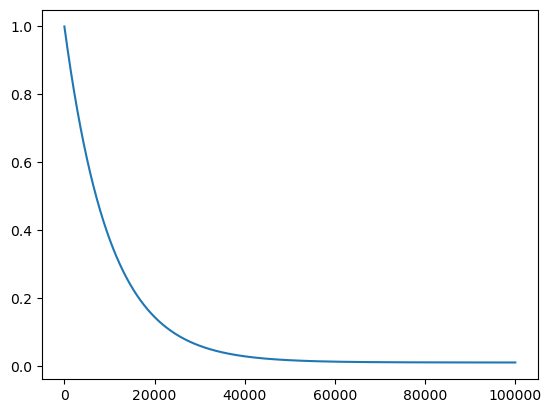

In [13]:
epsilon_by_frame = lambda frame: min_epsilon + (max_epsilon - min_epsilon) * np.exp(- decay_rate * frame)

plt.plot([epsilon_by_frame(i) for i in range(num_frames)])
plt.show()

### Initialise DQN Model

In [14]:
env.observation_space["screen"]

Box(0, 255, (240, 320, 3), uint8)

In [15]:
model = DQN(env.observation_space.shape[0], env.action_space.n)
model.to(device)

optimizer = optim.Adam(model.parameters(), lr = learning_rate)
replay_buffer = ReplayBuffer(10000)

TypeError: 'NoneType' object is not subscriptable

In [16]:
def compute_td_loss(batch_size):
    state, action, reward, next_state, done = replay_buffer.sample(batch_size)

    state = torch.FloatTensor(np.float32(state))
    next_state = torch.FloatTensor(np.float32(next_state))
    action = torch.LongTensor(action)
    reward = torch.FloatTensor(reward)
    done = torch.FloatTensor(done)

    q_values = model(state)
    next_q_values = model(next_state)

    q_value = q_values.gather(1, action.unsqueeze(1)).squeeze(1)
    next_q_value = next_q_values.max(1)[0]
    expected_q_value = reward + gamma * next_q_value * (1 - done)
    
    loss = (q_value - expected_q_value.data).pow(2).mean()
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss

In [17]:
def plot(frame_idx, rewards, losses):
    clear_output(True)
    plt.figure(figsize = (20, 5))
    plt.subplot(131)
    plt.title(f"Frame: {frame_idx}, Reward: {np.mean(rewards[-10:])}")
    plt.plot(rewards)
    plt.subplot(132)
    plt.title("Loss")
    plt.plot(losses)
    plt.show()

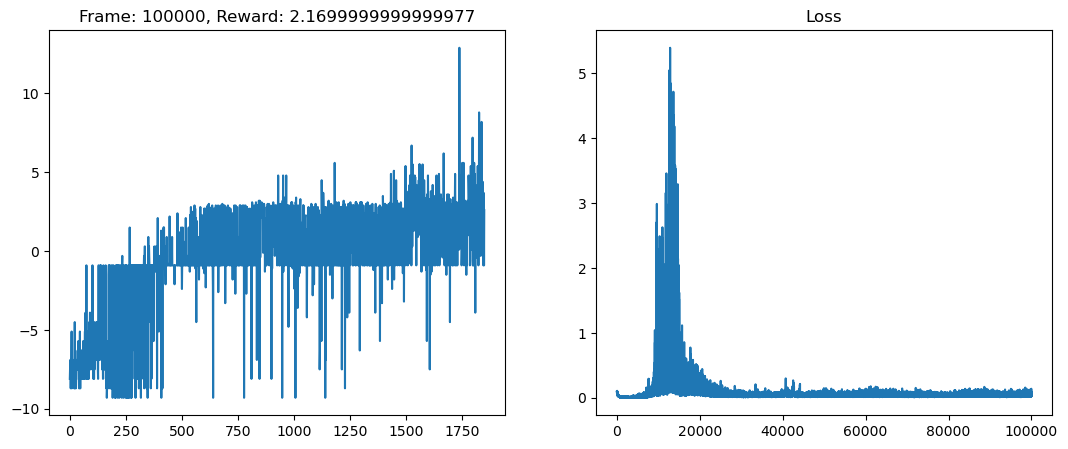

In [13]:
losses = []
all_rewards = []
episode_reward = 0

state, _ = env.reset()
for frame_idx in range(1, num_frames + 1):
    epsilon = epsilon_by_frame(frame_idx)
    action = model.act(state, epsilon)
    next_state, reward, done, _, _ = env.step(action)
    replay_buffer.push(state, action, reward, next_state, done)
    
    state = next_state
    episode_reward += reward
    
    if done:
        state, _ = env.reset()
        all_rewards.append(episode_reward)
        episode_reward = 0
        
    if len(replay_buffer) > batch_size:
        loss = compute_td_loss(batch_size)
        losses.append(loss.item())
        
    if frame_idx % 200 == 0:
        plot(frame_idx, all_rewards, losses)

In [84]:
import numpy as np
from collections import deque
import gymnasium as gym
from gymnasium import spaces
import cv2
cv2.ocl.setUseOpenCL(False)

class NoopResetEnv(gym.Wrapper):
    def __init__(self, env, noop_max=30):
        """Sample initial states by taking random number of no-ops on reset.
        No-op is assumed to be action 0.
        """
        gym.Wrapper.__init__(self, env)
        self.noop_max = noop_max
        self.override_num_noops = None
        self.noop_action = 0
        assert env.unwrapped.get_action_meanings()[0] == 'NOOP'

    def reset(self, **kwargs):
        """ Do no-op action for a number of steps in [1, noop_max]."""
        self.env.reset(**kwargs)
        if self.override_num_noops is not None:
            noops = self.override_num_noops
        else:
            noops = self.unwrapped.np_random.integers(1, self.noop_max + 1) #pylint: disable=E1101
        assert noops > 0
        obs = None
        for _ in range(noops):
            obs, _, done, _, _ = self.env.step(self.noop_action)
            if done:
                obs, _ = self.env.reset(**kwargs)
        return obs

    def step(self, ac):
        return self.env.step(ac)

class FireResetEnv(gym.Wrapper):
    def __init__(self, env):
        """Take action on reset for environments that are fixed until firing."""
        gym.Wrapper.__init__(self, env)
        assert env.unwrapped.get_action_meanings()[1] == 'FIRE'
        assert len(env.unwrapped.get_action_meanings()) >= 3

    def reset(self, **kwargs):
        self.env.reset(**kwargs)
        obs, _, done, _ = self.env.step(1)
        if done:
            self.env.reset(**kwargs)
        obs, _, done, _ = self.env.step(2)
        if done:
            self.env.reset(**kwargs)
        return obs

    def step(self, ac):
        return self.env.step(ac)

class EpisodicLifeEnv(gym.Wrapper):
    def __init__(self, env):
        """Make end-of-life == end-of-episode, but only reset on true game over.
        Done by DeepMind for the DQN and co. since it helps value estimation.
        """
        gym.Wrapper.__init__(self, env)
        self.lives = 0
        self.was_real_done  = True

    def step(self, action):
        obs, reward, done, info, _ = self.env.step(action)
        self.was_real_done = done
        # check current lives, make loss of life terminal,
        # then update lives to handle bonus lives
        lives = self.env.unwrapped.ale.lives()
        if lives < self.lives and lives > 0:
            # for Qbert sometimes we stay in lives == 0 condtion for a few frames
            # so its important to keep lives > 0, so that we only reset once
            # the environment advertises done.
            done = True
        self.lives = lives
        return obs, reward, done, info

    def reset(self, **kwargs):
        """Reset only when lives are exhausted.
        This way all states are still reachable even though lives are episodic,
        and the learner need not know about any of this behind-the-scenes.
        """
        if self.was_real_done:
            obs = self.env.reset(**kwargs)
        else:
            # no-op step to advance from terminal/lost life state
            obs, _, _, _, _ = self.env.step(0)
        self.lives = self.env.unwrapped.ale.lives()
        return obs

class MaxAndSkipEnv(gym.Wrapper):
    def __init__(self, env, skip=4):
        """Return only every `skip`-th frame"""
        gym.Wrapper.__init__(self, env)
        # most recent raw observations (for max pooling across time steps)
        self._obs_buffer = np.zeros((2,)+env.observation_space.shape, dtype=np.uint8)
        self._skip       = skip

    def reset(self):
        return self.env.reset()

    def step(self, action):
        """Repeat action, sum reward, and max over last observations."""
        total_reward = 0.0
        done = None
        for i in range(self._skip):
            obs, reward, done, info, _ = self.env.step(action)
            if i == self._skip - 2: self._obs_buffer[0] = obs
            if i == self._skip - 1: self._obs_buffer[1] = obs
            total_reward += reward
            if done:
                break
        # Note that the observation on the done=True frame
        # doesn't matter
        max_frame = self._obs_buffer.max(axis=0)

        return max_frame, total_reward, done, info

    def reset(self, **kwargs):
        return self.env.reset(**kwargs)

class ClipRewardEnv(gym.RewardWrapper):
    def __init__(self, env):
        gym.RewardWrapper.__init__(self, env)

    def reward(self, reward):
        """Bin reward to {+1, 0, -1} by its sign."""
        return np.sign(reward)

class WarpFrame(gym.ObservationWrapper):
    def __init__(self, env):
        """Warp frames to 84x84 as done in the Nature paper and later work."""
        gym.ObservationWrapper.__init__(self, env)
        self.width = 84
        self.height = 84
        self.observation_space = spaces.Box(low=0, high=255,
            shape=(self.height, self.width, 1), dtype=np.uint8)

    def observation(self, frame):
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        frame = cv2.resize(frame, (self.width, self.height), interpolation=cv2.INTER_AREA)
        return frame[:, :, None]

class FrameStack(gym.Wrapper):
    def __init__(self, env, k):
        """Stack k last frames.
        Returns lazy array, which is much more memory efficient.
        See Also
        --------
        baselines.common.atari_wrappers.LazyFrames
        """
        gym.Wrapper.__init__(self, env)
        self.k = k
        self.frames = deque([], maxlen=k)
        shp = env.observation_space.shape
        self.observation_space = spaces.Box(low=0, high=255, shape=(shp[0], shp[1], shp[2] * k), dtype=np.uint8)

    def reset(self):
        ob, _ = self.env.reset()
        for _ in range(self.k):
            self.frames.append(ob)
        return self._get_ob()

    def step(self, action):
        ob, reward, done, info, _ = self.env.step(action)
        self.frames.append(ob)
        return self._get_ob(), reward, done, info

    def _get_ob(self):
        assert len(self.frames) == self.k
        return LazyFrames(list(self.frames))

class ScaledFloatFrame(gym.ObservationWrapper):
    def __init__(self, env):
        gym.ObservationWrapper.__init__(self, env)

    def observation(self, observation):
        # careful! This undoes the memory optimization, use
        # with smaller replay buffers only.
        return np.array(observation).astype(np.float32) / 255.0

class LazyFrames(object):
    def __init__(self, frames):
        """This object ensures that common frames between the observations are only stored once.
        It exists purely to optimize memory usage which can be huge for DQN's 1M frames replay
        buffers.
        This object should only be converted to numpy array before being passed to the model.
        You'd not believe how complex the previous solution was."""
        self._frames = frames
        self._out = None

    def _force(self):
        if self._out is None:
            self._out = np.concatenate(self._frames, axis=2)
            self._frames = None
        return self._out

    def __array__(self, dtype=None):
        out = self._force()
        if dtype is not None:
            out = out.astype(dtype)
        return out

    def __len__(self):
        return len(self._force())

    def __getitem__(self, i):
        return self._force()[i]

def make_atari(env_id):
    env = gym.make(env_id)
    assert 'NoFrameskip' in env.spec.id
    env = NoopResetEnv(env, noop_max=30)
    env = MaxAndSkipEnv(env, skip=4)
    return env

def wrap_deepmind(env, episode_life=True, clip_rewards=True, frame_stack=False, scale=False):
    """Configure environment for DeepMind-style Atari.
    """
    if episode_life:
        env = EpisodicLifeEnv(env)
    if 'FIRE' in env.unwrapped.get_action_meanings():
        env = FireResetEnv(env)
    env = WarpFrame(env)
    if scale:
        env = ScaledFloatFrame(env)
    if clip_rewards:
        env = ClipRewardEnv(env)
    if frame_stack:
        env = FrameStack(env, 4)
    return env



class ImageToPyTorch(gym.ObservationWrapper):
    """
    Image shape to num_channels x weight x height
    """
    def __init__(self, env):
        super(ImageToPyTorch, self).__init__(env)
        old_shape = self.observation_space.shape
        self.observation_space = gym.spaces.Box(low=0.0, high=1.0, shape=(old_shape[-1], old_shape[0], old_shape[1]), dtype=np.uint8)

    def observation(self, observation):
        return np.swapaxes(observation, 2, 0)
    

def wrap_pytorch(env):
    return ImageToPyTorch(env)

env_id = "PongNoFrameskip-v4"
env    = make_atari(env_id)
env    = wrap_deepmind(env)
env    = wrap_pytorch(env)

In [152]:
class CnnDQN(nn.Module):
    def __init__(self, input_shape, num_actions):
        super(CnnDQN, self).__init__()
        
        self.input_shape = input_shape
        self.num_actions = num_actions
        
        self.features = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )
        
        self.fc = nn.Sequential(
            nn.Linear(self.feature_size(), 512),
            nn.ReLU(),
            nn.Linear(512, self.num_actions)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x
    
    def feature_size(self):
        return self.features(torch.zeros(1, *self.input_shape)).view(1, -1).size(1)
    
    def act(self, state, epsilon):
        if random.random() > epsilon:
            state   = torch.FloatTensor(np.float32(state)).unsqueeze(0)
            q_value = self.forward(state)
            action  = int(q_value.max(1)[1].data[0])
        else:
            action = random.randrange(env.action_space.n)
        return action

In [153]:
#env = gym.wrappers.AtariPreprocessing(env)
env = None
env_id = "PongNoFrameskip-v4"
env = gym.make(env_id)
env.observation_space

Box(0, 255, (210, 160, 3), uint8)

In [154]:
from gym.spaces import Box
from gym.wrappers import FrameStack
from torchvision import transforms as T

class SkipFrame(gym.Wrapper):
    def __init__(self, env, skip):
        """Return only every `skip`-th frame"""
        super().__init__(env)
        self._skip = skip

    def step(self, action):
        """Repeat action, and sum reward"""
        total_reward = 0.0
        for i in range(self._skip):
            # Accumulate reward and repeat the same action
            obs, reward, done, trunk, info = self.env.step(action)
            total_reward += reward
            if done:
                break
        return obs, total_reward, done, trunk, info


class GrayScaleObservation(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        obs_shape = self.observation_space.shape[:2]
        self.observation_space = Box(low=0, high=255, shape=obs_shape, dtype=np.uint8)

    def permute_orientation(self, observation):
        # permute [H, W, C] array to [C, H, W] tensor
        observation = np.transpose(observation, (2, 0, 1))
        observation = torch.tensor(observation.copy(), dtype=torch.float)
        return observation

    def observation(self, observation):
        observation = self.permute_orientation(observation)
        transform = T.Grayscale()
        observation = transform(observation)
        return observation


class ResizeObservation(gym.ObservationWrapper):
    def __init__(self, env, shape):
        super().__init__(env)
        if isinstance(shape, int):
            self.shape = (shape, shape)
        else:
            self.shape = tuple(shape)

        obs_shape = self.shape + self.observation_space.shape[2:]
        self.observation_space = Box(low=0, high=255, shape=obs_shape, dtype=np.uint8)

    def observation(self, observation):
        transforms = T.Compose(
            [T.Resize(self.shape, antialias=True), T.Normalize(0, 255)]
        )
        observation = transforms(observation).squeeze(0)
        return observation


# Apply Wrappers to environment
env = SkipFrame(env, skip=4)
env = GrayScaleObservation(env)
env = ResizeObservation(env, shape=84)
if gym.__version__ < '0.26':
    env = FrameStack(env, num_stack=4, new_step_api=True)
else:
    env = FrameStack(env, num_stack=4)

In [155]:
env.observation_space.shape, env.action_space.n

((4, 84, 84), 6)

In [156]:
IMAGE_SHAPE = (84, 84)
FRAME_SKIP = 4

class ObservationWrapper(gym.ObservationWrapper):
    """
    ViZDoom environments return dictionaries as observations, containing
    the main image as well other info.
    The image is also too large for normal training.

    This wrapper replaces the dictionary observation space with a simple
    Box space (i.e., only the RGB image), and also resizes the image to a
    smaller size.

    NOTE: Ideally, you should set the image size to smaller in the scenario files
          for faster running of ViZDoom. This can really impact performance,
          and this code is pretty slow because of this!
    """

    def __init__(self, env, shape=IMAGE_SHAPE):
        super().__init__(env)
        self.image_shape = shape
        self.image_shape_reverse = shape[::-1]
        self.env.frame_skip = FRAME_SKIP

        # Create new observation space with the new shape
        print(env.observation_space)
        num_channels = env.observation_space["screen"].shape[-1]
        new_shape = (shape[0], shape[1], num_channels)
        self.observation_space = gym.spaces.Box(
            0, 255, shape=new_shape, dtype=np.uint8
        )

    def observation(self, observation):
        observation = cv2.resize(observation["screen"], self.image_shape_reverse)
        return observation

In [187]:
env = None
env_id = "VizdoomBasic-v0"
#env = gym.make(env_id, render_mode = "human")
env = gym.make(env_id, frame_skip = 4)
#env.observation_space = env.observation_space["screen"]
#env = ObservationWrapper(env)
#env = gym.wrappers.TransformReward(env, lambda r: r * 0.01)
env.observation_space, env.action_space.n

(Dict('gamevariables': Box(-3.4028235e+38, 3.4028235e+38, (1,), float32), 'screen': Box(0, 255, (240, 320, 3), uint8)),
 4)

class GrayScaleObservation(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        obs_shape = self.observation_space.shape[:2]
        self.observation_space = Box(low=0, high=255, shape=obs_shape, dtype=np.uint8)

    def permute_orientation(self, observation):
        # permute [H, W, C] array to [C, H, W] tensor
        observation = np.transpose(observation, (2, 0, 1))
        observation = torch.tensor(observation.copy(), dtype=torch.float)
        return observation

    def observation(self, observation):
        observation = self.permute_orientation(observation)
        transform = T.Grayscale()
        observation = transform(observation)
        return observation

In [188]:
from gym.spaces import Box
from gym.wrappers import FrameStack, GrayScaleObservation
from torchvision import transforms as T
import cv2

class ObservationWrapper(gym.ObservationWrapper):
    """
    ViZDoom environments return dictionaries as observations, containing
    the main image as well other info.
    The image is also too large for normal training.

    This wrapper replaces the dictionary observation space with a simple
    Box space (i.e., only the RGB image), and also resizes the image to a
    smaller size.

    NOTE: Ideally, you should set the image size to smaller in the scenario files
          for faster running of ViZDoom. This can really impact performance,
          and this code is pretty slow because of this!
    """

    def __init__(self, env, shape = (84, 84)):
        super().__init__(env)
        self.image_shape = shape
        self.image_shape_reverse = shape[::-1]

        # Create new observation space with the new shape
        print(env.observation_space)
        num_channels = env.observation_space["screen"].shape[-1]
        new_shape = (shape[0], shape[1], num_channels)
        self.observation_space = gym.spaces.Box(
            0, 255, shape=new_shape, dtype=np.uint8
        )

    def observation(self, observation):
        observation = cv2.resize(observation["screen"], self.image_shape_reverse)
        return observation

class GrayScaleObservation(gym.ObservationWrapper):
    """Convert the image observation from RGB to gray scale.

    Example:
        >>> env = gym.make('CarRacing-v1')
        >>> env.observation_space
        Box(0, 255, (96, 96, 3), uint8)
        >>> env = GrayScaleObservation(gym.make('CarRacing-v1'))
        >>> env.observation_space
        Box(0, 255, (96, 96), uint8)
        >>> env = GrayScaleObservation(gym.make('CarRacing-v1'), keep_dim=True)
        >>> env.observation_space
        Box(0, 255, (96, 96, 1), uint8)
    """

    def __init__(self, env: gym.Env, keep_dim: bool = False):
        """Convert the image observation from RGB to gray scale.

        Args:
            env (Env): The environment to apply the wrapper
            keep_dim (bool): If `True`, a singleton dimension will be added, i.e. observations are of the shape AxBx1.
                Otherwise, they are of shape AxB.
        """
        super().__init__(env)
        self.keep_dim = keep_dim

        assert (
            isinstance(self.observation_space, gym.spaces.Box)
            and len(self.observation_space.shape) == 3
            and self.observation_space.shape[-1] == 3
        )

        obs_shape = self.observation_space.shape[:2]
        if self.keep_dim:
            self.observation_space = Box(
                low=0, high=255, shape=(obs_shape[0], obs_shape[1], 1), dtype=np.uint8
            )
        else:
            self.observation_space = Box(
                low=0, high=255, shape=obs_shape, dtype=np.uint8
            )

    def observation(self, observation):
        """Converts the colour observation to greyscale.

        Args:
            observation: Color observations

        Returns:
            Grayscale observations
        """
        import cv2

        observation = cv2.cvtColor(observation, cv2.COLOR_RGB2GRAY)
        if self.keep_dim:
            observation = np.expand_dims(observation, -1)
        return observation

# Apply Wrappers to environment
#env = SkipFrame(env, skip=4)
env = ObservationWrapper(env)
env = GrayScaleObservation(env)
env = gym.wrappers.TransformReward(env, lambda r: r * 0.01)
if gym.__version__ < '0.26':
    env = FrameStack(env, num_stack=4, new_step_api=True)
else:
    env = FrameStack(env, num_stack=4)

Dict('gamevariables': Box(-3.4028235e+38, 3.4028235e+38, (1,), float32), 'screen': Box(0, 255, (240, 320, 3), uint8))


In [189]:
env.observation_space.shape, env.action_space.n

((4, 84, 84), 4)

In [190]:
model = CnnDQN(env.observation_space.shape, env.action_space.n)
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.00001)

replay_initial = 10000
replay_buffer = ReplayBuffer(100000)

In [191]:
epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 30000

epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay)

In [192]:
def plot(frame_idx, rewards, losses):
    clear_output(True)
    plt.figure(figsize = (20, 5))
    plt.subplot(131)
    plt.title(f"Frame: {frame_idx}, Reward: {np.mean(rewards[-10:])}")
    plt.plot(rewards)
    plt.subplot(132)
    plt.title("Loss")
    plt.plot(losses)
    plt.show()

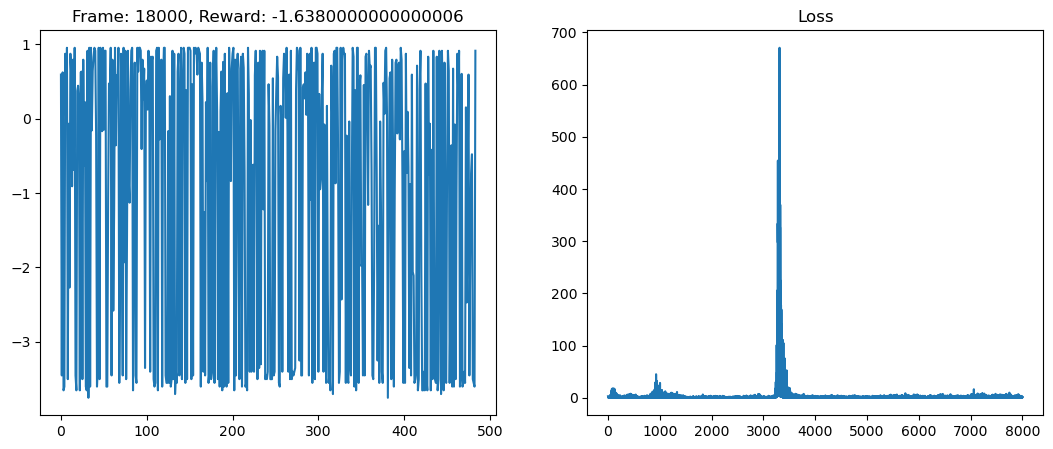

KeyboardInterrupt: 

In [193]:
num_frames = 1400000
batch_size = 32
gamma      = 0.99

losses = []
all_rewards = []
episode_reward = 0

state, _ = env.reset()
for frame_idx in range(1, num_frames + 1):
    epsilon = epsilon_by_frame(frame_idx)
    #print(f"Frame: {frame_idx}, State: {state}")
    action = model.act(state, epsilon)
    #print(action)
    next_state, reward, done, _, _ = env.step(action)

    replay_buffer.push(state, action, reward, next_state, done)
    
    state = next_state
    episode_reward += reward
    
    if done:
        state, _ = env.reset()
        all_rewards.append(episode_reward)
        episode_reward = 0
        
    if len(replay_buffer) > replay_initial:
        loss = compute_td_loss(batch_size)
        losses.append(loss.item())
        
    if frame_idx % 1000 == 0:
        plot(frame_idx, all_rewards, losses)